In [9]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
import jax.numpy.fft as jfft
from numpy import sqrt

In [10]:
def fft2(x):
    """Applies a 2D FFT over the first two dimensions of the input array x."""
    return fftn(x, axes=(0, 1))

def ifft2(x):
    """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
    return ifftn(x, axes=(0, 1))

In [11]:
def FNOBlock2D(modes):
    def compl_mul2d(input, weights):
        return jnp.einsum("jixy,ikxy->jkxy", input, weights)

    def init_fun(rng, input_shape):
        k1, k2 = random.split(rng)
        W1 = random.normal(k1, (input_shape[1], input_shape[1], modes, modes))
        W2 = random.normal(k2, (input_shape[1], input_shape[1], modes, modes))
        return input_shape, (W1, W2)

    def apply_fun(params, inputs, **kwargs):
        W1, W2 = params
        x_ft = fft2(inputs)
        out_ft = jnp.zeros_like(x_ft)
        out_ft = out_ft.at[:, :, : W1.shape[2], : W1.shape[3]].set(compl_mul2d(x_ft[:, :, : W1.shape[2], : W1.shape[3]], W1))
        out_ft = out_ft.at[:, :, -W2.shape[2] :, : W2.shape[3]].set(compl_mul2d(x_ft[:, :, -W2.shape[2] :, : W2.shape[3]], W2))
        return ifft2(out_ft)

    return init_fun, apply_fun



In [12]:
def Permute(order):
    def permutation_indices(order):
        if order == "ijkl->iljk":
            return (0, 3, 1, 2)
        elif order == "ijkl->iklj":
            return (0, 2, 3, 1)
        else:
            raise NotImplementedError

    def init_fun(rng, input_shape):
        idx = permutation_indices(order)
        output_shape = tuple([input_shape[i] for i in idx])
        return output_shape, ()

    def apply_fun(params, inputs, **kwargs):
        outputs = jnp.einsum(order, inputs)
        return outputs

    return init_fun, apply_fun



In [13]:
@optimizer
def complex_adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = make_schedule(step_size)
    def init(x0):
        m0 = jnp.zeros_like(x0)
        v0 = jnp.zeros_like(x0)
        return x0, m0, v0, jnp.zeros(())
    def update(i, g, state):
        x, m, v, t = state
        t = t + 1
        m = (1 - b1) * g + b1 * m
        v = (1 - b2) * (g * jnp.conj(g)) + b2 * v
        mhat = m / (1 - b1 ** t)
        vhat = v / (1 - b2 ** t)
        step = step_size(i) * mhat / (jnp.sqrt(vhat) + eps)
        x = x - step
        return x, m, v, t
    def get_params(state):
        x, m, v, t = state
        return x
    return init, update, get_params

In [18]:
# def normalize_data(data):
#     """
#     Normalize 2D data to the range [-1, 1].

#     Parameters:
#     data (jnp.ndarray): 2D array to be normalized.

#     Returns:
#     jnp.ndarray: Normalized 2D array.
#     """
#     min_val = jnp.min(data)
#     max_val = jnp.max(data)
#     normalized_data = 2 * (data - min_val) / (max_val - min_val) - 1
#     return normalized_data





In [15]:
class SPiFOL:
    def __init__(self,L, eps, pp2, qq2, dt, h, arch, N, fno_layers, lr, activation, norm_par):
        self.arch = arch
        self.N = N
        self.lr = lr
        self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.h = h
        self.L = L

        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
        else:
            raise ValueError("Unsupported architecture!")

        self.params = params

        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(lr)
        self.opt_state = self.opt_init(self.params)

        # Logging losses
        self.total_loss_log = []

        # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        self.itercount = iter(range(10000))

    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            uk = uk.reshape(-1, self.N, self.N, 1)  # Reshape input strain tensor
            O = self.N_apply(params, uk)  # Apply the FNO network
            O = jnp.real(O)  # Take the real part of the output
            O = O.reshape(self.N, self.N)  # Reshape output
            return O
        else:
            raise ValueError("Unsupported architecture type!")
        
    @partial(jit, static_argnums=(0,))
    def allen_cahn_equation(self, uk):
        cahn = self.eps**2 #cahn number 
        uk = jnp.real(uk)
            # Transforming the solution to the discrete Fourier space
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) # us is the real space
        v_hat = s_hat / (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2)))  # Allen-Cahn equation
        u_k1= jfft.ifft2(v_hat)  # u_k+1 result
        return jnp.real(u_k1)

    @partial(jit, static_argnums=(0,))
    # def laplacian(self, u):
    #     return (jnp.roll(u, 1, axis=0) + jnp.roll(u, -1, axis=0) +
    #             jnp.roll(u, 1, axis=1) + jnp.roll(u, -1, axis=1) - 4 * u) / (self.h ** 2)

    def laplacian(self, u):
        factor = (self.N ** 4) / (self.L ** 2)  # Incorporates h^2 / N^2
        return factor * (jnp.roll(u, 1, axis=0) + jnp.roll(u, -1, axis=0) +
                     jnp.roll(u, 1, axis=1) + jnp.roll(u, -1, axis=1) - 4 * u)

    # @partial(jit, static_argnums=(0,))
    # def nonlinear_term(self, u):
    #     return u ** 3 - u

    def nonlinear_term(self, u):
    # Compute h^2
        h_squared = (self.L / self.N) ** 2
    # Scaling factor
        scaling_factor = h_squared / (self.eps ** 2)
    # Nonlinear term with scaling
        return scaling_factor * (u ** 3 - u)

    # def nonlinear_term(u):
    #     return jnp.power(u, 3) - u

    # grad_nonlinear = grad(nonlinear_term)

    @partial(jit, static_argnums=(0,))
    def total_energy(self, u):
        laplacian_u = self.laplacian(u)
        nonlinear_u = self.nonlinear_term(u)
        energy = 0.5 * jnp.sum(laplacian_u ** 2) + jnp.sum(nonlinear_u)
        return energy

    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk, u_gt):
        u_pred = self.operator_net(params, uk)
        u_pred = u_pred.reshape(self.N, self.N)
        
        # Allen-Cahn equation loss
        energy_loss = self.total_energy(u_pred)
        distance_loss = jnp.mean((u_gt - u_pred) ** 2)
        total_loss = distance_loss + energy_loss
        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk, u_gt):
        params = self.get_params(opt_state)
        grads = grad(self.loss_single)(params, uk, u_gt)
        return self.opt_update(i, grads, opt_state)

    def train(self, uk, nIter=10000):
        u_gt = self.allen_cahn_equation(uk) #gt is ground truth
        pbar = trange(nIter)

        for it in pbar:
            self.opt_state = self.step(next(self.itercount), self.opt_state, uk, u_gt)

            # Logger (log the loss every 100 iterations)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_single(params, uk, u_gt)
                self.total_loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s, Loss=3.5954688e+20]


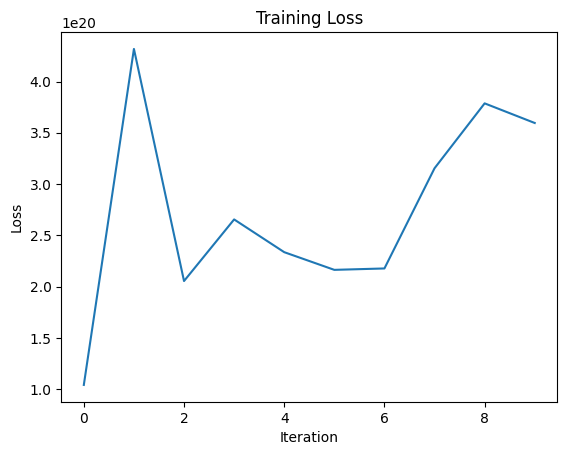

In [16]:
# Parameters

N = 128 # no. of grid point
eps = 0.05
lr = 0.001
L = 2.0 * jnp.pi                                    
h = L / N 
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 20 #number of snapshots



# Generate input condition
xx, yy = jnp.meshgrid(jnp.linspace(-0.5*L+h,0.5*L,N), jnp.linspace(-0.5*L+h,0.5*L,N))
input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2) * eps)
input_condition = normalize_data(input_condition)

# # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])


# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
# #print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# Define FNO layers
fno_layers = [
    Dense(32),
    Permute("ijkl->iljk"),
    FNOBlock2D(32),
    Gelu,  # activation can be changed here
    FNOBlock2D(32),
    Gelu,
    FNOBlock2D(32),
    Permute("ijkl->iklj"),
    Dense(128),
    Gelu,
    Dense(1),
]

# Initialize and train the model
model = SPiFOL(L, eps, pp2, qq2, dt, h, arch='FNO', N=N, fno_layers=fno_layers, lr=lr, activation=jax.nn.relu, norm_par=1000.0)
model.train(input_condition, nIter=1000)

# params = model.get_params(model.opt_state)
# model_prediction = model.operator_net(params, input_condition).reshape(N, N)

# Plot the figures
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# contour_levels = 20
# axs[0].contour(xx,yy, jnp.real(input_condition.T),levels=[0], colors="green")
# axs[0].set_title('Input Condition')
# axs[0].axis('off')
# axs[0].set_aspect('equal', adjustable='box')
# # plt.gca().set_aspect('equal', adjustable='box') 

# # Plot model prediction
# # axs[1].contour(xx,yy, jnp.real(input_condition_i.T),levels=[0], colors="green")

# axs[1].contour(xx, yy, jnp.real(model_prediction.T), levels=[0], colors="red")
# axs[1].set_title('Model Prediction')
# axs[1].axis('off')
# axs[1].set_aspect('equal', adjustable='box')


# # Plot loss
# axs[2].plot(model.total_loss_log)
# axs[2].set_title('Training Loss')
# axs[2].set_xlabel('Iteration')
# axs[2].set_ylabel('Loss')

# plt.tight_layout()
# plt.show()

# Plot the loss
plt.plot(model.total_loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [17]:
# # difinning the no of grid points in x, y and z
# Nx = 128 # number of grid points in x be positive even integer number
# Ny = 128 # number of grid points in y be positive even integer number




# # Define the parameters of the Allen-Cahn equation in 2d
# Lx = 2.0 * jnp.pi #length of the domain in x
# Ly = 2.0 * jnp.pi #length of the domain in y
# hx = Lx / Nx #spatial step size in coordinate x
# hy = Ly / Ny #spatial step size in coordinate y
# print(f'hx ko size = {hx}')
# dt = 0.0001 #time step size
# T = 4 #final time
# Nt = int(jnp.round(T/dt)) #number of time steps
# ns = Nt / 20 #number of snapshots

# # Define the grid points in x and y direction
# def x_gridpoint(Nx, Lx, hx):
#     x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
#     return x
# x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
# def y_gridpoint(Ny, Ly, hy):
#     y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
#     return y
# y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# # creating meshgrid in x and y direction
# xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# # defining parameters for the Allen-Cahn equation
# epsillon = 0.05 #small parameter
# cahn = epsillon**2 #cahn number  

# # initial condition of allen cahn equation
# u =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation
# # theta = jnp.arctan(y/x)
# # u =jnp.tanh((1.7 - 1.2 * jnp.cos(6*theta) - sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))


# # defining the wavenumber in x and y direction , which is in fourier space
# p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
# q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# # square of wavenumber in x and y direction
# p2 = p**2 # square of wavenumber in x direction
# q2 = q**2 # square of wavenumber in y direction

# # creating meshgrid in x and y direction for square of wavenumber
# pp2, qq2 = jnp.meshgrid(p2, q2)
# #print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# # # plotting the initial condition of the Allen-Cahn equation

# # figure1 = plt.figure()
# # plt.contour(x, y, jnp.real(u.T), [0])
# # plt.gca().set_aspect('equal', adjustable='box') 
# # plt.title('Initial condition')
# # plt.xlabel('x')
# # plt.ylabel('y')
# # plt.show()



# # # # providing the range of iteration

# # for iter in range(1, Nt):
# #     u = jnp.real(u)
# #     # print(f'real space u ko size ={u.shape}')
# #     # Transforming the solution to the discrete Fourier space
# #     s_hat = jfft.fft2(cahn * u - dt * (u**3 - 3 * u)) # us is the real space
# #     # print(f's_hat ko size = {s_hat.shape}')
# #     v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))  # Allen-Cahn equation
# #     u = jfft.ifft2(v_hat)  # u_k+1 result
# #     # print(f'inverse u ko size = {u.shape}')
    

# #     if iter % ns == 0:
# #         plt.contour(x, y, jnp.real(u.T), [0], colors='red')
# #         plt.gca().set_aspect('equal', adjustable='box') 
    
# # plt.title('Numerical Solutions after iteration ' + str(Nt))
# # plt.show()



